In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df_enc = pd.read_csv("data/enc/data-enc-2024-04-07.csv")

In [3]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85823 entries, 0 to 85822
Data columns (total 86 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   avg_price_5                       85823 non-null  float64
 1   bathrooms_total                   85823 non-null  float64
 2   bedrooms_extra                    85823 non-null  float64
 3   bedrooms                          85823 non-null  float64
 4   stories_total                     85823 non-null  float64
 5   size_interior                     85823 non-null  float64
 6   lng                               85823 non-null  float64
 7   lat                               85823 non-null  float64
 8   parkings                          85823 non-null  float64
 9   price                             85823 non-null  float64
 10  household_income                  85823 non-null  float64
 11  individual_income                 85823 non-null  float64
 12  comm

In [4]:
df_ON = df_enc[df_enc["province_Ontario"] == True]
df_QC = df_enc[df_enc["province_Quebec"] == True]
df_BC = df_enc[df_enc["province_British Columbia"] == True]
df_AB = df_enc[df_enc["province_Alberta"] == True]
df_SK = df_enc[df_enc["province_Saskatchewan"] == True]
df_MB = df_enc[df_enc["province_Manitoba"] == True]
# East
df_ES = df_enc[(df_enc["province_Nova Scotia"] == True) |
               (df_enc["province_New Brunswick"] == True) |
               (df_enc["province_Newfoundland & Labrador"] == True) |
               (df_enc["province_Prince Edward Island"] == True)]
# North
df_NO = df_enc[(df_enc["province_Yukon"] == True) |
               (df_enc["province_Northwest Territories"] == True)]

df_ON = df_ON.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_QC = df_QC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_BC = df_BC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_AB = df_AB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_SK = df_SK.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_MB = df_MB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_ES = df_ES.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan","province_Manitoba", "province_Yukon", "province_Northwest Territories"], axis=1)
df_NO = df_NO.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan", "province_Manitoba", "province_Nova Scotia", "province_New Brunswick",
                    "province_Newfoundland & Labrador", "province_Prince Edward Island"], axis=1)

In [5]:
df_QC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7282 entries, 18819 to 83624
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   avg_price_5                    7282 non-null   float64
 1   bathrooms_total                7282 non-null   float64
 2   bedrooms_extra                 7282 non-null   float64
 3   bedrooms                       7282 non-null   float64
 4   stories_total                  7282 non-null   float64
 5   size_interior                  7282 non-null   float64
 6   lng                            7282 non-null   float64
 7   lat                            7282 non-null   float64
 8   parkings                       7282 non-null   float64
 9   price                          7282 non-null   float64
 10  household_income               7282 non-null   float64
 11  individual_income              7282 non-null   float64
 12  commute_transit                7282 non-null   f

In [6]:
df_ON.corr(numeric_only=True)["price"].sort_values(ascending=False).head(20)

price                         1.000000
avg_price_5                   0.656434
size_interior                 0.531458
bathrooms_total               0.514122
individual_income             0.463992
household_income              0.463992
bedrooms                      0.367889
parkings                      0.344413
building_type_House           0.270852
single_family                 0.258912
edu_bachelor_degree           0.252914
ownership_type_group_ids_1    0.241954
edu_university_certificate    0.234721
stories_total                 0.225005
edu_post_graduate_degree      0.213510
owners                        0.205558
bedrooms_extra                0.204302
age_15_to_19                  0.169841
multi_family                  0.155906
area_single_detached          0.155107
Name: price, dtype: float64

## Raw Input

In [7]:
kf = KFold(n_splits=10)

In [8]:
cb1 = CatBoostRegressor(silent=True)

X = df_ON.drop("price", axis=1)
y = df_ON["price"]

scores1 = cross_val_score(cb1, X, y, cv=kf, scoring="r2")

print(f"\n{scores1}\n")
pd.Series(scores1).describe()


[0.55637523 0.69850933 0.74892504 0.68286581 0.55193956 0.53904732
 0.64465585 0.70244834 0.65770696 0.67222573]



count    10.000000
mean      0.645470
std       0.072295
min       0.539047
25%       0.578445
50%       0.664966
75%       0.694598
max       0.748925
dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cb1.fit(X_train, y_train)
y_pred = cb1.predict(X_test)

In [10]:
r2_score(y_test, y_pred)

0.7023018898544202

In [11]:
root_mean_squared_error(y_test, y_pred)

303632.09779408027

In [12]:
y_df1 = pd.DataFrame({"y_test":y_test.values, "y_pred":y_pred})

In [13]:
np.round(y_df1.head(20))

,y_test,y_pred
0,879900.0,783431.0
1,619900.0,650184.0
2,949900.0,1045956.0
3,1699900.0,2173908.0
4,1049900.0,1093319.0
5,950000.0,674269.0
6,764900.0,779380.0
7,539900.0,562939.0
8,559000.0,512471.0
9,879000.0,824914.0


## Scaled

In [14]:
cb2 = CatBoostRegressor(silent=True)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores2 = cross_val_score(cb2, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores2}\n")
pd.Series(scores2).describe()


[0.54402331 0.69572818 0.74973124 0.68525576 0.55070052 0.52819575
 0.63694317 0.69997073 0.65670255 0.67012474]



count    10.000000
mean      0.641738
std       0.075750
min       0.528196
25%       0.572261
50%       0.663414
75%       0.693110
max       0.749731
dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb2.fit(X_train, y_train)
y_pred = cb2.predict(X_test)

In [16]:
r2_score(y_test, y_pred)

0.7019368742914827

In [23]:
root_mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred.reshape(-1,1)))

303818.1864609221

In [18]:
y_df2 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [19]:
np.round(y_df2.head(20))

,y_test,y_pred
0,879900.0,752096.0
1,619900.0,643630.0
2,949900.0,1040149.0
3,1699900.0,2141956.0
4,1049900.0,1110475.0
5,950000.0,673406.0
6,764900.0,796193.0
7,539900.0,558396.0
8,559000.0,504896.0
9,879000.0,825377.0


## log1p: X Only

In [20]:
from scipy import stats

sub_df = df_AB.copy(deep=True)

skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_Before"] = sub_df.corr()["price"].values
skew_df["Skew_Before"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_Before"] = skew_df["Skew_Before"].apply(abs)
skew_df["Skewed_Before"] = skew_df["AbsSkew_Before"].apply(lambda x: True if x>= 0.5 else False)

# before_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

for column in skew_df.query("Skewed_Before == True")["Feature"].values:
    if column != "price":
        sub_df[column] = np.log1p(sub_df[column])


# skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_After"] = sub_df.corr()["price"].values
skew_df["Skew_After"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_After"] = skew_df["Skew_After"].apply(abs)
skew_df["Skewed_After"] = skew_df["AbsSkew_After"].apply(lambda x: True if x>= 0.5 else False)

# after_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

# log_columns = list(before_log - after_log - {"price", "lng", "lat"})
log_columns = skew_df[(skew_df["Skewed_Before"]==True) & (skew_df["Corr_Price_After"] > skew_df["Corr_Price_Before"])]["Feature"].values

log_columns

/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


array(['bedrooms_extra', 'commute_transit', 'commute_drive',
       'age_65_to_79', 'lang_en_only', 'lang_en_and_fr',
       'area_apt_5_plus_floors', 'loc_transit_friendly', 'loc_wellness',
       'building_type_Apartment', 'building_type_House',
       'building_type_Semi-Detached', 'ownership_type_group_ids_2'],
      dtype=object)

In [21]:
cb3 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores3 = cross_val_score(cb3, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores3}\n")
pd.Series(scores3).describe()

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb3.fit(X_train, y_train)
y_pred = cb3.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

0.6439168820882428

In [ ]:
root_mean_squared_error(y_test, y_pred)

In [ ]:
y_df3 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [ ]:
np.round(y_df3.head(20))

,y_test,y_pred
0,749000.0,662950.0
1,799000.0,445426.0
2,459900.0,527647.0
3,449000.0,454009.0
4,379900.0,390256.0
5,599000.0,606594.0
6,295000.0,274550.0
7,439900.0,457362.0
8,629900.0,585511.0
9,1050000.0,790094.0


# log1p: X and y

In [ ]:
cb4 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

y_log = np.log1p(y)

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y_log.to_numpy().reshape(-1,1))

scores4 = cross_val_score(cb4, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores4}\n")
pd.Series(scores4).describe()


[0.34941043 0.72300756 0.52458584 0.21453028 0.55880121 0.72537294
 0.52423622 0.4973602  0.69522507 0.57335155]



count    10.000000
mean      0.538588
std       0.162602
min       0.214530
25%       0.504079
50%       0.541694
75%       0.664757
max       0.725373
dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb4.fit(X_train, y_train)
y_pred = cb4.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

0.6154937374816809

### Reverse Log

In [ ]:
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.36334329420732414

In [ ]:
root_mean_squared_error(y_test, y_pred)

In [ ]:
y_df4 = pd.DataFrame({"y_test":np.expm1(scaler_y.inverse_transform(y_test))[:,0].tolist(),
                      "y_pred":np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist())})

In [ ]:
np.round(y_df4.head(20))

,y_test,y_pred
0,749000.0,652058.0
1,799000.0,438325.0
2,459900.0,533981.0
3,449000.0,446184.0
4,379900.0,388903.0
5,599000.0,606493.0
6,295000.0,270528.0
7,439900.0,445661.0
8,629900.0,551573.0
9,1050000.0,710566.0


In [ ]:
np.round(y_df3.head(20))

,y_test,y_pred
0,749000.0,662950.0
1,799000.0,445426.0
2,459900.0,527647.0
3,449000.0,454009.0
4,379900.0,390256.0
5,599000.0,606594.0
6,295000.0,274550.0
7,439900.0,457362.0
8,629900.0,585511.0
9,1050000.0,790094.0


/tmp/ipykernel_2605/305300287.py:2: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
/tmp/ipykernel_2605/305300287.py:3: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))


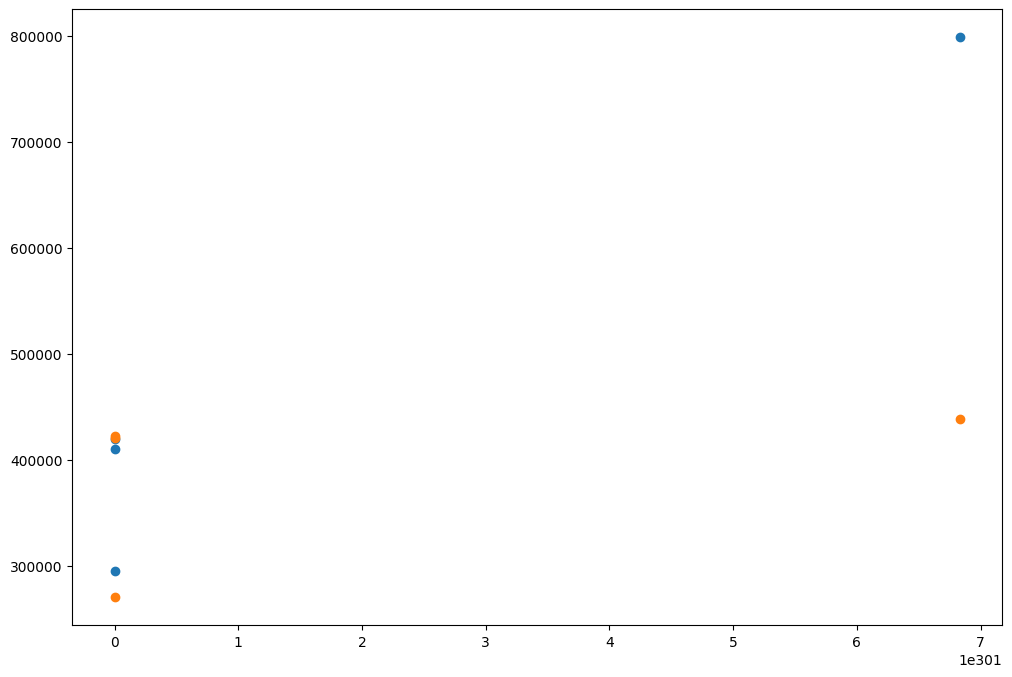

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

In [ ]:
r2_score(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

0.5698550550737254

In [ ]:
X_log

,avg_price_5,bathrooms_total,bedrooms_extra,bedrooms,stories_total,size_interior,lng,lat,parkings,household_income,...,loc_parks,building_type_Apartment,building_type_House,building_type_Row / Townhouse,building_type_Semi-Detached,ownership_type_group_ids_0,ownership_type_group_ids_1,ownership_type_group_ids_2,province_Northwest Territories,province_Yukon
56443,811740.0,3.0,0.0,4.0,1.0,2334.0,-137.503728,60.754328,0.0,123000.00000,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,0.0,1.0
56444,761740.0,4.0,0.0,4.0,1.0,2472.0,-137.516981,60.755222,0.0,123000.00000,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,0.0,1.0
56445,769560.0,3.0,0.0,5.0,1.0,2300.0,-137.491731,60.763404,0.0,123000.00000,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,0.0,1.0
56446,699740.0,3.0,0.0,4.0,1.0,2200.0,-136.187886,60.769378,0.0,132867.01604,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,0.0,1.0
56447,603940.0,3.0,0.0,3.0,1.0,1586.0,-135.112776,60.784982,0.0,188400.00000,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85818,469740.0,3.0,0.0,3.0,1.0,1635.0,-114.414275,62.441185,0.0,190434.87480,...,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0
85819,715740.0,2.0,0.0,3.0,1.0,2140.0,-114.425597,62.450687,0.0,220114.32600,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,1.0,0.0
85820,453920.0,2.0,0.0,3.0,1.0,1369.0,-114.409428,62.441894,0.0,133685.37690,...,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0
85821,409920.0,3.0,0.0,4.0,1.0,1668.0,-114.405637,62.443042,0.0,133685.37690,...,0.0,0.0,0.693147,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
y

56443    399000.0
56444    649000.0
56445    609900.0
56446    749900.0
56447    689000.0
           ...   
85818    369900.0
85819    875000.0
85820    409900.0
85821    629900.0
85822    415000.0
Name: price, Length: 147, dtype: float64

In [ ]:
df_log = X_log.copy(deep=True)
df_log["price_log"] = np.log1p(y)

In [ ]:
df_log.corr(numeric_only=True)["price_log"].sort_values(ascending=False).head(20)

price_log                     1.000000
size_interior                 0.700449
bathrooms_total               0.474645
bedrooms                      0.432614
ownership_type_group_ids_0    0.382445
building_type_House           0.287020
avg_price_5                   0.261640
commute_drive                 0.235031
lang_en_and_fr                0.228351
owners                        0.201671
single_family                 0.191286
age_35_to_49                  0.175496
edu_bachelor_degree           0.161558
loc_car_friendly              0.161140
area_single_detached          0.149924
household_children            0.121653
household_income              0.115173
individual_income             0.115173
age_15_to_19                  0.113816
edu_high_school               0.108277
Name: price_log, dtype: float64